### Importing Required Libraries

In [8]:
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np

### Building the Convolution Neural Networks Model

In [9]:

model =Sequential([
    Conv2D(100, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(100, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 100)     2800      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 100)       90100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 129600)            0         
                                                                 
 dropout (Dropout)           (None, 129600)            0

## Training the Model

In [10]:
TRAINING_DIR = "./train"
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=10, 
                                                    target_size=(150, 150))
VALIDATION_DIR = "./test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, 
                                                         batch_size=10, 
                                                         target_size=(150, 150))


Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model2-{epoch:03d}.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

history = model.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[checkpoint])
model.load_weights('model2-008.h5')


Epoch 1/10
132/132 [==============================] - 85s 628ms/step - loss: 0.4340 - acc: 0.8053 - val_loss: 0.1906 - val_acc: 0.9227
Epoch 2/10
 29/132 [=====>........................] - ETA: 43s - loss: 0.3284 - acc: 0.8724

KeyboardInterrupt: 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


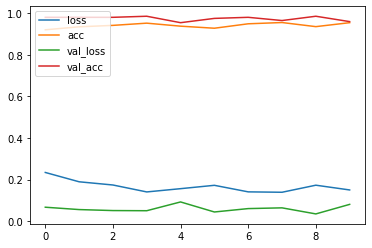

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

plt.plot(pd.DataFrame(history.history))
plt.legend(history.history.keys(), loc='upper left')
print(history.history.keys())

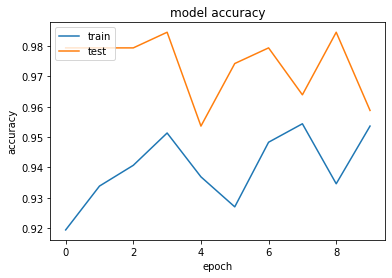

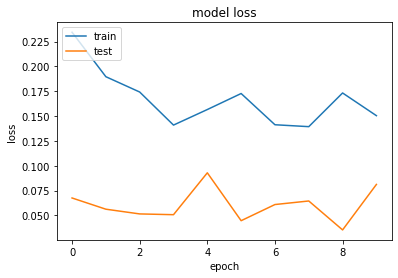

In [9]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
plt.style.context('Solarize_Light2')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy:', accuracy)

20/20 [==============================] - 2s 113ms/step - loss: 0.0558 - acc: 0.9897
Test accuracy: 0.9896907210350037


In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image

In [21]:
img_path = './mask.jpeg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 150.0

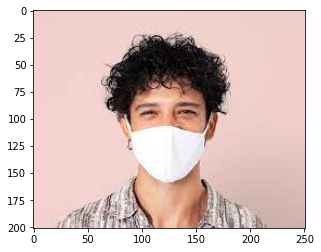

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)
plt.imshow(img)
plt.show()


In [23]:
prediction = model.predict(img_array)

# Print the predicted class
predicted_class = np.argmax(prediction)
if predicted_class == 0:
    print('Masked')
else:
    print('Unmasked')

1/1 [==============================] - 0s 73ms/step
Masked


# Testing the Model

In [12]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

## Predicting using my model with harcascade

In [13]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

model = load_model('model2-008.h5')

labels = ['Without Mask', 'With Mask']

colors = [(0, 0, 255), (0, 255, 0)]

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]

        face = cv2.resize(face, (150, 150))

        face = np.expand_dims(face, axis=0)
        face = face / 255.0

        pred = model.predict(face)[0]

        label = labels[pred.argmax()]
        score = pred[pred.argmax()]

        print(label, " ", score)
        color = colors[pred.argmax()]
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        cv2.putText(frame, label + ' ({:.2f}%)'.format(score*100), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    cv2.imshow('Face Mask Detection', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 167ms/step
Without Mask   0.9561972
1/1 [==============================] - 0s 57ms/step
Without Mask   0.95891404
1/1 [==============================] - 0s 56ms/step
Without Mask   0.9663793
1/1 [==============================] - 0s 48ms/step
Without Mask   0.95993555
1/1 [==============================] - 0s 57ms/step
Without Mask   0.96309495
1/1 [==============================] - 0s 56ms/step
Without Mask   0.97204316
1/1 [==============================] - 0s 55ms/step
Without Mask   0.96925586
1/1 [==============================] - 0s 56ms/step
Without Mask   0.9890977
1/1 [==============================] - 0s 56ms/step
Without Mask   0.99036646
1/1 [==============================] - 0s 56ms/step
Without Mask   0.9903031
1/1 [==============================] - 0s 56ms/step
Without Mask   0.9965342
1/1 [==============================] - 0s 49ms/step
Without Mask   0.9978156
1/1 [==============================] - 0s 48ms/step
Without Mask   0.

KeyboardInterrupt: 

In [7]:
cap.release()
cv2.destroyAllWindows()